# Dataset Generator for FullDA-FM

In [1]:
__author__ = "Ludovico Scarton, Alexander Hagg"
__version__= 0.1
__email__ = "ludovico.scarton@gmail.com, alexander.hagg@h-brs.de"

This is a dataset generator created to support the work of Michael Loomis for training ANN.

It can be used to perform:
* encoding-decoding $f(𝕯) = \hat{𝕯}$
* regression $f(𝕯) = \vec{y}$

In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from pyDOE2 import lhs

In [12]:
grid_size = 30
num_samples = 10000 # 5_000_000
num_selected_samples = 1000 # 50_000
min_building_size = 20 # Make sure there is a building that is large enough
num_periodical_fcns = 1 # In theory we can add more periodical functions but leave it at 1 for now

# Generator Parameter Definitions
parameter_ranges_2d = np.array([
    [0, 10],  # k (frequency)
    [0, 0],  # theta (angle)
    [1, 1],  # amplitude
    [0, 2 * np.pi]  # phase
])

parameter_ranges_1d = np.array([
    [1, 20],  # k (frequency)
    [1, 1],  # amplitude
    [0, 2 * np.pi],  # phase
    [0, 1] # x or y direction
])

In [8]:
def sinusoidal_2d_pattern(x, y, k, theta, amplitude=1, phase=0):
    return amplitude * np.sin(k * x * np.cos(theta) + k * y * np.sin(theta) + phase)

def sinusoidal_1d_pattern(t, k, amplitude=1, phase=0):
    return amplitude * np.sin(k * t + phase)

def generate_1d_2d_design(grid_size, params_2d, params_1d_list):
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    i = 1
    for params_1d in params_1d_list:
        # Half of the time, use pattern in direction of x axis, other half in the direction of the y axis
        if params_1d[3] > 0.5:
            Z += np.tile(sinusoidal_1d_pattern(x, *params_1d[0:2]), (grid_size, 1))
        else:
            Z += np.tile(np.array([sinusoidal_1d_pattern(y, *params_1d[0:2])]).transpose(), (1, grid_size))
        i += 1
    # Z = np.digitize(Z, bins=np.array([-2.25, -0.75, 0.75, 2.25]))
    Z = Z / num_periodical_fcns
    Z = np.digitize(Z, bins=np.array([0.5, 0.7, 0.8, 0.9]))
    return Z

def modified_fitness_function(design):
    fitness = np.sum(np.max(design, axis=0))
    if fitness < min_building_size:
        fitness = 9999
    return fitness

def create_dataset(num_samples:int, num_selected_samples: int) -> npt.ArrayLike:
    """
    Create valid design. the map is filled with values between 0 and 3, where 0 is no voxel and 3 is 3 voxels vertically stucked.

    parameters:
        num_samples (int): number of design samples.
        num_selected_samples (int): number of selected best samples.

    return:
        𝕯 np.array: tensor of shape [num_selected_samples, grid_size, grid_size] with valid designs.
        y⃗ np.array: vector of shape [num_selected_samples] with the fitness values.
    """
    # Define X and Y for the grid size
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(x, y)

    # Sample parameters of mask function with latin hypercube sampling
    samples_mask = lhs(4, samples=num_samples)
    samples_scaled_mask = parameter_ranges_2d[:, 0] + samples_mask * (parameter_ranges_2d[:, 1] - parameter_ranges_2d[:, 0])

    # Sample parameters of generating sine function with latin hypercube sampling
    samples_1d = lhs(4, samples=num_samples*num_periodical_fcns)
    samples_scaled_1d = parameter_ranges_1d[:, 0] + samples_1d * (parameter_ranges_1d[:, 1] - parameter_ranges_1d[:, 0])
    params_1d_list = [samples_scaled_1d[i].tolist() for i in range(num_samples)] * num_periodical_fcns

    # Create masks and preliminary designs
    masks = [np.where(sinusoidal_2d_pattern(X, Y, *params_2d) > 0, 1, 0) for params_2d in samples_scaled_mask]
    preliminary_designs = [generate_1d_2d_design(grid_size, [0, 0, 0, 0], params_1d_list[i:i+num_periodical_fcns]) for i in range(0, num_samples*num_periodical_fcns, num_periodical_fcns)]
    masked_designs = [preliminary_designs[i] * masks[i] for i in range(len(preliminary_designs))]
    
    # Calculate fitness
    fitness_values_masked = [modified_fitness_function(design) for design in masked_designs]

    # Select based on fitness
    sorted_indices_masked = np.argsort(fitness_values_masked)
    selected_indices_masked = sorted_indices_masked[:(num_selected_samples)]
    selected_designs_masked = [masked_designs[i] for i in selected_indices_masked]
    fitness_values = [fitness_values_masked[i] for i in selected_indices_masked]
    
    return selected_designs_masked, fitness_values


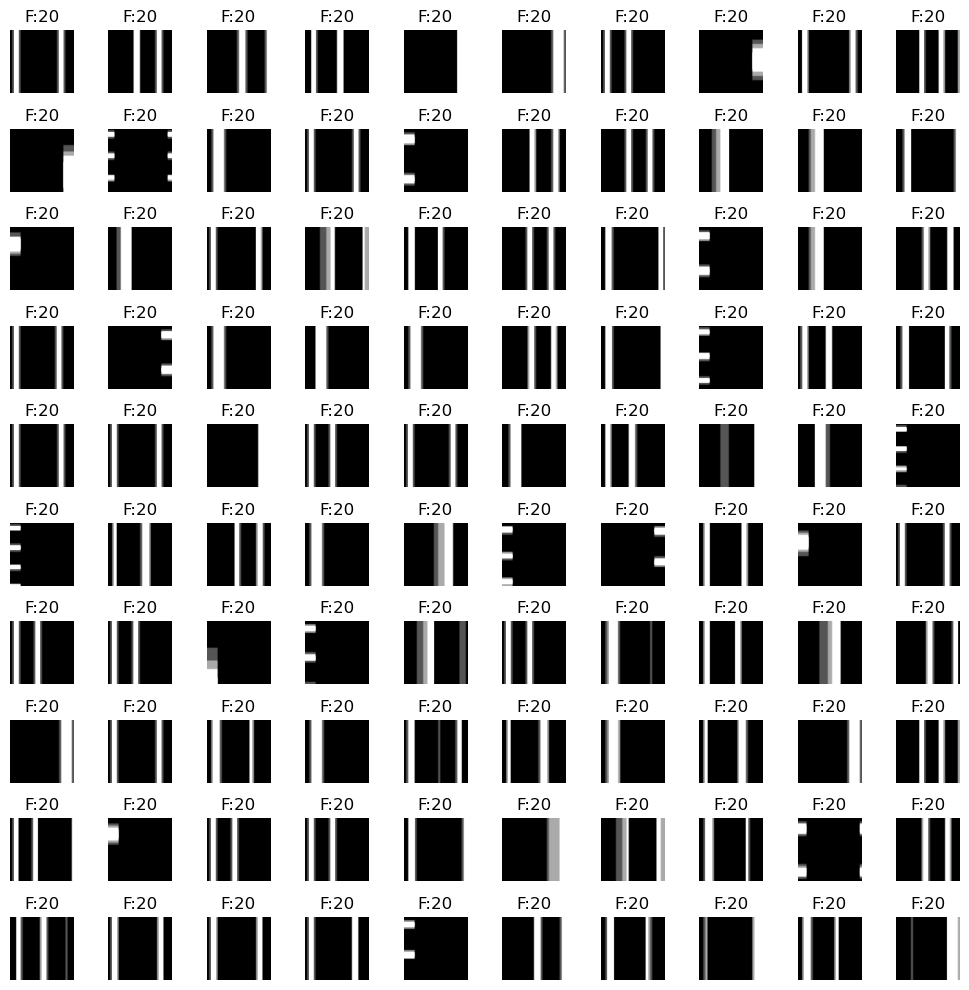

In [13]:
selected_designs_masked, fitness_values = create_dataset(num_samples, num_selected_samples)

num_plots_per_axis = 10
fig, axs = plt.subplots(num_plots_per_axis, num_plots_per_axis, figsize=(10, 10))
for i in range(num_plots_per_axis):
    for j in range(num_plots_per_axis):
        axs[i, j].imshow(selected_designs_masked[num_plots_per_axis * i + j], cmap='gray', vmin=0, vmax=3)
        axs[i, j].axis('off')
        axs[i, j].set_title(f'F:{fitness_values[num_plots_per_axis * i + j]}')
plt.tight_layout()
plt.show()

Good luck with your project!! =)
Ludovico & Alex